In [532]:
import pandas as pd
import plotly.express as px
import scipy.stats as stats
import geopandas as gpd
from shapely.geometry import Point
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [533]:
data = pd.read_csv("../data/landing/alt_properties.csv")

In [ ]:
## testing

In [534]:
data.head(5)

URL  \
0  https://www.domain.com.au/8-37-nepean-highway-...   
1  https://www.domain.com.au/8-25-hobart-road-mur...   
2  https://www.domain.com.au/1-472-mountain-highw...   
3  https://www.domain.com.au/2-21-glen-huntly-roa...   
4  https://www.domain.com.au/23-whittens-lane-don...   

                 Rent_Price                                    Address  \
0  <span>$415 weekly</span>  8/37 Nepean Highway, Elsternwick VIC 3185   
1         <span>$380</span>     8/25 Hobart Road, Murrumbeena VIC 3163   
2         <span>$730</span>  1/472 Mountain Highway, Wantirna VIC 3152   
3  <span>$600 weekly</span>     2/21 Glen Huntly Road, Elwood VIC 3184   
4         <span>$995</span>       23 Whittens Lane, Doncaster VIC 3108   

  Bedrooms Bathrooms Parking            Property_Type   Latitude   Longitude  \
0        1         1       1  Apartment / Unit / Flat -37.887226  145.000425   
1        1         1       1  Apartment / Unit / Flat -37.886645  145.069922   
2        4         3       2                    House -37.844725  145.244003   
3        2         1       1  Apartment / Unit / Flat -37.881703  144.980493   
4        4         3       2                    House -37.793835  145.127920   

                                   Property_Headline  \
0  One Bedroom Apartment In Prime Location With A...   
1                Get Comfortable In A Great Location   
2                            Luxury Family Townhouse   
3                  BIG 2 BEDROOM ART DECO APARTMENT.   
4  Prime Doncaster Location: Walk to Westfield, C...   

                                Property_Description  
0  *** Please click "register now" to receive inf...  
1  This recently painted one-bedroom apartment is...  
2  This luxury four bedroom townhouse, one of two...  
3  This property is a gem nestled close to the be...  
4  Looking for the perfect family home in a prime...

## Cleaning & Preprocess

In [535]:
data['Rent_Price'] = (
    data['Rent_Price']
    .replace(',', '', regex=True)  
    .str.extract(r'\$\s*([\d,]+\.\d+|\d+)')[0]
    .fillna(0) 
    .astype(float)  
)


In [536]:

data[['Street', 'Suburb', 'Postcode']] = data['Address'].str.extract(
    r'^(?:(.*?),\s*)?([A-Za-z\s]+)\s+VIC\s+(\d+)$', expand=True)


data.head(5)

URL  Rent_Price  \
0  https://www.domain.com.au/8-37-nepean-highway-...       415.0   
1  https://www.domain.com.au/8-25-hobart-road-mur...       380.0   
2  https://www.domain.com.au/1-472-mountain-highw...       730.0   
3  https://www.domain.com.au/2-21-glen-huntly-roa...       600.0   
4  https://www.domain.com.au/23-whittens-lane-don...       995.0   

                                     Address Bedrooms Bathrooms Parking  \
0  8/37 Nepean Highway, Elsternwick VIC 3185        1         1       1   
1     8/25 Hobart Road, Murrumbeena VIC 3163        1         1       1   
2  1/472 Mountain Highway, Wantirna VIC 3152        4         3       2   
3     2/21 Glen Huntly Road, Elwood VIC 3184        2         1       1   
4       23 Whittens Lane, Doncaster VIC 3108        4         3       2   

             Property_Type   Latitude   Longitude  \
0  Apartment / Unit / Flat -37.887226  145.000425   
1  Apartment / Unit / Flat -37.886645  145.069922   
2                    House -37.844725  145.244003   
3  Apartment / Unit / Flat -37.881703  144.980493   
4                    House -37.793835  145.127920   

                                   Property_Headline  \
0  One Bedroom Apartment In Prime Location With A...   
1                Get Comfortable In A Great Location   
2                            Luxury Family Townhouse   
3                  BIG 2 BEDROOM ART DECO APARTMENT.   
4  Prime Doncaster Location: Walk to Westfield, C...   

                                Property_Description                  Street  \
0  *** Please click "register now" to receive inf...     8/37 Nepean Highway   
1  This recently painted one-bedroom apartment is...        8/25 Hobart Road   
2  This luxury four bedroom townhouse, one of two...  1/472 Mountain Highway   
3  This property is a gem nestled close to the be...   2/21 Glen Huntly Road   
4  Looking for the perfect family home in a prime...        23 Whittens Lane   

        Suburb Postcode  
0  Elsternwick     3185  
1  Murrumbeena     3163  
2     Wantirna     3152  
3       Elwood     3184  
4    Doncaster     3108

In [537]:
data = data.dropna(subset=['Latitude', 'Longitude'])

In [538]:
data['geometry'] = data.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
geo_data = gpd.GeoDataFrame(data, geometry='geometry')

In [539]:
import requests
api_key = '5b3ce3597851110001cf624852cb481f85234e34aa33962c065e48ef'
cbd_lat = -37.8136
cbd_lon = 144.9631
locations = [[cbd_lon, cbd_lat]] + [[point.x, point.y] for point in data['geometry']]  # point.x = Longitude, point.y = Latitude

mid_index = len(locations) // 2  

location1 = locations[:mid_index]  
location2 = [locations[0]] + locations[mid_index:]  

body1 = {
    "locations": location1,
    "destinations": list(range(1, len(location1))), 
    "metrics": ["duration", "distance"],
    "sources": [0] 
}

headers = {
    'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
    'Authorization': api_key,
    'Content-Type': 'application/json; charset=utf-8'
}

try:
    call1 = requests.post('https://api.openrouteservice.org/v2/matrix/driving-car', json=body1, headers=headers)
    call1.raise_for_status()  
    print(call1.status_code, call1.reason)

    response_data1 = call1.json()
    durations1 = response_data1.get("durations", [[]])[0]  
    distances1 = response_data1.get("distances", [[]])[0]  

    # print("Durations (first batch):", durations1)
    # print("Distances (first batch):", distances1)

except requests.exceptions.RequestException as e:
    print(f"Request failed: {e}")


200 OK
Durations (first batch): [1272.08, 1540.37, 2122.8, 1124.51, 1476.69, 5756.12, 3131.74, 3555.61, 1596.92, 4076.28, 2722.66, 1591.72, 1330.01, 1578.2, 2865.7, 2189.1, 708.08, 5766.59, 407.85, 671.52, 1438.24, 1664.26, 4116.47, 388.98, 1200.94, 3361.7, 8366.88, 7026.43, 530.83, 3053.98, 1039.2, 2093.37, 1666.3, 2624.14, 708.95, 1596.73, 2239.16, 1606.13, 1483.66, 2808.77, 941.74, 332.06, 1885.18, 1638.51, 1244.11, 938.19, 1340.12, 13045.43, 1174.35, 1181.34, 3167.28, 1115.3, 638.92, 1435.51, 1112.33, 957.28, 1680.26, 4138.49, 587.52, 632.47, 3920.22, 407.55, 2171.12, 1874.73, 369.02, 2306.5, 121.57, 5660.08, 2021.18, 2135.87, 1582.75, 1447.61, 1919.33, 2226.79, 991.17, 2124.59, 686.07, 970.3, 946.86, 1318.48, 16118.49, 185.13, 773.04, 12946.1, 747.94, 2983.27, 954.07, 6826.29, 7283.6, 4123.2, 5445.55, 1118.61, 1687.39, 2560.62, 1133.46, 2879.95, 7369.53, 4864.12, 1228.14, 2979.65, 3442.1, 1390.75, 499.24, 1959.67, 330.8, 1715.93, 1717.94, 2607.32, 2475.24, 2241.24, 1689.32, 6355.7

In [540]:
body2 = {"locations":location2,"destinations":list(range(1, len(location2))),"metrics":["duration", "distance"],"sources":[0]}
headers = {
    'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
    'Authorization': api_key,
    'Content-Type': 'application/json; charset=utf-8'
}
call2 = requests.post('https://api.openrouteservice.org/v2/matrix/driving-car', json=body2, headers=headers)

print(call2.status_code, call2.reason)
# print(call2.text)
durations2 = call2.json()["durations"][0]
distances2 = call2.json()['distances'][0]
combined_durations = durations1 + durations2
combined_distances = distances1 + distances2
# print("Combined durations:", combined_durations)
data['Duration_to_CBD_sec'] = combined_durations
data['Duration_to_CBD_sec'] = data['Duration_to_CBD_sec']/60
data['Distances_to_CBD_km'] = combined_distances 
data['Distances_to_CBD_km'] = data['Distances_to_CBD_km']/1000
data

200 OK
{"durations":[[3414.69,3040.6,1767.29,5054.16,1296.59,3092.93,1431.46,3899.73,1912.53,1220.39,408.69,868.68,4768.0,218.96,5601.12,440.23,6022.5,5119.82,2960.69,1557.39,611.09,2115.12,2010.73,3889.71,2203.71,2978.66,1877.99,1623.21,13078.87,6916.48,1043.22,3098.68,11497.35,1422.19,1398.23,1999.39,6266.65,982.19,1726.26,1448.73,2034.67,1308.73,22989.43,1064.08,5293.72,2705.79,2360.21,1651.22,4932.85,1205.36,5145.14,2677.62,1076.36,1640.8,1608.1,751.07,1359.73,1436.5,1781.91,2416.62,169.59,2619.06,22689.47,1048.88,1915.53,2610.81,12733.77,885.29,1019.86,1639.76,5622.29,2523.58,582.26,3473.63,1435.51,791.71,1069.63,782.77,10118.82,5529.42,2686.86,1633.72,1012.84,2087.24,4258.64,701.51,300.05,1107.89,1490.82,2418.88,2453.56,1441.38,470.12,7233.18,1507.19,1890.52,10479.63,4096.19,224.81,7223.37,3942.66,1202.13,2231.48,4258.46,442.2,2999.75,966.92,858.85,645.73,5507.34,1598.63,503.59,577.6,4308.76,2247.48,8684.4,1484.07,1736.97,1216.48,4212.84,7226.31,1090.44,1709.96,2014.46,3025.12,20

URL  Rent_Price  \
0     https://www.domain.com.au/8-37-nepean-highway-...       415.0   
1     https://www.domain.com.au/8-25-hobart-road-mur...       380.0   
2     https://www.domain.com.au/1-472-mountain-highw...       730.0   
3     https://www.domain.com.au/2-21-glen-huntly-roa...       600.0   
4     https://www.domain.com.au/23-whittens-lane-don...       995.0   
...                                                 ...         ...   
6110  https://www.domain.com.au/83-verdale-drive-alf...       480.0   
6111  https://www.domain.com.au/7-32-church-road-car...       480.0   
6112  https://www.domain.com.au/3-80-munro-street-co...       545.0   
6113  https://www.domain.com.au/29b-gwynne-street-ha...       625.0   
6114  https://www.domain.com.au/33-waterbury-street-...       590.0   

                                         Address Bedrooms Bathrooms Parking  \
0      8/37 Nepean Highway, Elsternwick VIC 3185        1         1       1   
1         8/25 Hobart Road, Murrumbeena VIC 3163        1         1       1   
2      1/472 Mountain Highway, Wantirna VIC 3152        4         3       2   
3         2/21 Glen Huntly Road, Elwood VIC 3184        2         1       1   
4           23 Whittens Lane, Doncaster VIC 3108        4         3       2   
...                                          ...      ...       ...     ...   
6110        83 Verdale Drive, Alfredton VIC 3350        4         2       2   
6111           7/32 Church Road, Carrum VIC 3197        2         1       1   
6112          3/80 Munro Street, Coburg VIC 3058        2         1       1   
6113  29B Gwynne Street, Hamlyn Heights VIC 3215        3         3       2   
6114    33 Waterbury Street, Cranbourne VIC 3977        4         2       2   

                Property_Type   Latitude   Longitude  \
0     Apartment / Unit / Flat -37.887226  145.000425   
1     Apartment / Unit / Flat -37.886645  145.069922   
2                       House -37.844725  145.244003   
3     Apartment / Unit / Flat -37.881703  144.980493   
4                       House -37.793835  145.127920   
...                       ...        ...         ...   
6110                    House -37.561140  143.787691   
6111                    House -38.080475  145.128032   
6112                    Villa -37.744185  144.959125   
6113                Townhouse -38.127207  144.333164   
6114                    House -38.084328  145.289037   

                                      Property_Headline  \
0     One Bedroom Apartment In Prime Location With A...   
1                   Get Comfortable In A Great Location   
2                               Luxury Family Townhouse   
3                     BIG 2 BEDROOM ART DECO APARTMENT.   
4     Prime Doncaster Location: Walk to Westfield, C...   
...                                                 ...   
6110   LUXURIOUS FOUR BEDROOM HOME IN POPULAR ALFREDTON   
6111             Inviting and vibrant open-plan living!   
6112                 EASY LIVING, UNPARALLELED LOCATION   
6113   Luxurious living with long term lease available!   
6114                               Conveniently Located   

                                   Property_Description  \
0     *** Please click "register now" to receive inf...   
1     This recently painted one-bedroom apartment is...   
2     This luxury four bedroom townhouse, one of two...   
3     This property is a gem nestled close to the be...   
4     Looking for the perfect family home in a prime...   
...                                                 ...   
6110  BOOK YOUR INSPECTION ONLINE 24/7 Click "Book a...   
6111  This beautifully designed home offers an open-...   
6112  Proudly positioned in this fully renovated bou...   
6113  Brand new architect designed home with luxury ...   
6114  This home is walking to distance to Springhill...   

                      Street          Suburb Postcode  \
0        8/37 Nepean Highway     Elsternwick     3185   
1           8/25 Hobart Road     Murrumbeena 

In [541]:
data = data.rename({"Duration_to_CBD_sec": "Duration_to_CBD_min"})

In [542]:
shapefile_path = '../data/landing/SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp'
gdf = gpd.read_file(shapefile_path)

In [543]:
gdf

SA2_CODE21                            SA2_NAME21 CHG_FLAG21  CHG_LBL21  \
0     101021007                             Braidwood          0  No change   
1     101021008                               Karabar          0  No change   
2     101021009                            Queanbeyan          0  No change   
3     101021010                     Queanbeyan - East          0  No change   
4     101021012       Queanbeyan West - Jerrabomberra          0  No change   
...         ...                                   ...        ...        ...   
2468  901031003                            Jervis Bay          0  No change   
2469  901041004                        Norfolk Island          0  No change   
2470  997979799  Migratory - Offshore - Shipping (OT)          0  No change   
2471  999999499                 No usual address (OT)          0  No change   
2472  ZZZZZZZZZ                     Outside Australia          1        New   

     SA3_CODE21                            SA3_NAME21 SA4_CODE21  \
0         10102                            Queanbeyan        101   
1         10102                            Queanbeyan        101   
2         10102                            Queanbeyan        101   
3         10102                            Queanbeyan        101   
4         10102                            Queanbeyan        101   
...         ...                                   ...        ...   
2468      90103                            Jervis Bay        901   
2469      90104                        Norfolk Island        901   
2470      99797  Migratory - Offshore - Shipping (OT)        997   
2471      99999                 No usual address (OT)        999   
2472      ZZZZZ                     Outside Australia        ZZZ   

                                SA4_NAME21 GCC_CODE21  \
0                           Capital Region      1RNSW   
1                           Capital Region      1RNSW   
2                           Capital Region      1RNSW   
3                           Capital Region      1RNSW   
4                           Capital Region      1RNSW   
...                                    ...        ...   
2468                     Other Territories      9OTER   
2469                     Other Territories      9OTER   
2470  Migratory - Offshore - Shipping (OT)      99799   
2471                 No usual address (OT)      99499   
2472                     Outside Australia      ZZZZZ   

                                GCC_NAME21 STE_CODE21         STE_NAME21  \
0                              Rest of NSW          1    New South Wales   
1                              Rest of NSW          1    New South Wales   
2                              Rest of NSW          1    New South Wales   
3                              Rest of NSW          1    New South Wales   
4                              Rest of NSW          1    New South Wales   
...                                    ...        ...                ...   
2468                     Other Territories          9  Other Territories   
2469                     Other Territories          9  Other Territories   
2470  Migratory - Offshore - Shipping (OT)          9  Other Territories   
2471                 No usual address (OT)          9  Other Territories   
2472                     Outside Australia          Z  Outside Australia   

     AUS_CODE21         AUS_NAME21  AREASQKM21  \
0           AUS          Australia   3418.3525   
1           AUS          Australia      6.9825   
2           AUS          Australia      4.7620   
3           AUS          Australia     13.0032   
4           AUS          Australia     13.6748   
...         ...                ...         ...   
2468        AUS          Australia     67.2296   
2469        AUS          Australia     38.6510   
2470        AUS          Australia         NaN   
2471        AUS          Australia         NaN   
2472        ZZZ  Outside Australia         NaN   

                                        

In [544]:
gdf['STE_NAME21'].unique()
gdf = gdf.loc[gdf['STE_NAME21'] == 'Victoria']

In [545]:
data['geometry'] = gpd.points_from_xy(data['Longitude'], data['Latitude'])
data_gdf = gpd.GeoDataFrame(data, geometry='geometry', crs="EPSG:4326")
gdf = gdf.rename(columns={'geometry': 'suburb_geometry'})
gdf = gdf.set_geometry('suburb_geometry')
gdf = gdf.to_crs(data_gdf.crs)
result_gdf = gpd.sjoin(data_gdf, gdf, how='left', predicate='within')


In [546]:
gdf

SA2_CODE21                              SA2_NAME21 CHG_FLAG21  CHG_LBL21  \
644   201011001                               Alfredton          0  No change   
645   201011002                                Ballarat          0  No change   
646   201011005                               Buninyong          0  No change   
647   201011006                               Delacombe          0  No change   
648   201011007                           Smythes Creek          0  No change   
...         ...                                     ...        ...        ...   
1163  217041478                            Moyne - West          0  No change   
1164  217041479                     Warrnambool - North          0  No change   
1165  217041480                     Warrnambool - South          0  No change   
1166  297979799  Migratory - Offshore - Shipping (Vic.)          0  No change   
1167  299999499                 No usual address (Vic.)          0  No change   

     SA3_CODE21                              SA3_NAME21 SA4_CODE21  \
644       20101                                Ballarat        201   
645       20101                                Ballarat        201   
646       20101                                Ballarat        201   
647       20101                                Ballarat        201   
648       20101                                Ballarat        201   
...         ...                                     ...        ...   
1163      21704                             Warrnambool        217   
1164      21704                             Warrnambool        217   
1165      21704                             Warrnambool        217   
1166      29797  Migratory - Offshore - Shipping (Vic.)        297   
1167      29999                 No usual address (Vic.)        299   

                                  SA4_NAME21 GCC_CODE21  \
644                                 Ballarat      2RVIC   
645                                 Ballarat      2RVIC   
646                                 Ballarat      2RVIC   
647                                 Ballarat      2RVIC   
648                                 Ballarat      2RVIC   
...                                      ...        ...   
1163              Warrnambool and South West      2RVIC   
1164              Warrnambool and South West      2RVIC   
1165              Warrnambool and South West      2RVIC   
1166  Migratory - Offshore - Shipping (Vic.)      29799   
1167                 No usual address (Vic.)      29499   

                                  GCC_NAME21 STE_CODE21 STE_NAME21 AUS_CODE21  \
644                             Rest of Vic.          2   Victoria        AUS   
645                             Rest of Vic.          2   Victoria        AUS   
646                             Rest of Vic.          2   Victoria        AUS   
647                             Rest of Vic.          2   Victoria        AUS   
648                             Rest of Vic.          2   Victoria        AUS   
...                                      ...        ...        ...        ...   
1163                            Rest of Vic.          2   Victoria        AUS   
1164                            Rest of Vic.          2   Victoria        AUS   
1165                            Rest of Vic.          2   Victoria        AUS   
1166  Migratory - Offshore - Shipping (Vic.)          2   Victoria        AUS   
1167                 No usual address (Vic.)          2   Victoria        AUS   

     AUS_NAME21  AREASQKM21  \
644   Australia     52.7109   
645   Australia     12.3787   
646   Australia     51.5855   
647   Australia     34.1607   
648   Australia    104.7274   
...         ...         ...   
1163  Australia   2037.7626   
1164  Australia     62.4199   
1165  Australia    120.1957   
1166  Australia         NaN   
1167  Australia         NaN   

                                             LOCI_URI21  \
644   http://linked.data.gov.au/dataset/asgsed3/SA2/...   
645   http://linke

In [547]:
merged_gdf = result_gdf.merge(gdf, on="SA2_CODE21", how="inner", suffixes=('', '_polygon'))
columns_to_keep = ['URL', 'Rent_Price', 'Address', 'Bedrooms', 'Bathrooms', 'Parking',
       'Property_Type', 'Latitude', 'Longitude', 'Property_Headline',
       'Property_Description', 'Street', 'Suburb', 'Postcode', 'geometry',
       'Duration_to_CBD_sec', 'Distances_to_CBD_km', 'SA2_CODE21', 'SA2_NAME21', 'AREASQKM21', 'LOCI_URI21'] + ['suburb_geometry']
merged_gdf= merged_gdf[columns_to_keep]

In [548]:
merged_gdf.columns

Index(['URL', 'Rent_Price', 'Address', 'Bedrooms', 'Bathrooms', 'Parking',
       'Property_Type', 'Latitude', 'Longitude', 'Property_Headline',
       'Property_Description', 'Street', 'Suburb', 'Postcode', 'geometry',
       'Duration_to_CBD_sec', 'Distances_to_CBD_km', 'SA2_CODE21',
       'SA2_NAME21', 'AREASQKM21', 'LOCI_URI21', 'suburb_geometry'],
      dtype='object')

In [549]:
Q1 = merged_gdf['Rent_Price'].quantile(0.25)
Q3 = merged_gdf['Rent_Price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = merged_gdf[(merged_gdf['Rent_Price'] < lower_bound) | (merged_gdf['Rent_Price'] > upper_bound)]
print(len(outliers))

584


In [550]:
outliers.head()

URL  Rent_Price  \
5   https://www.domain.com.au/7-72-orrong-road-els...      1850.0   
10  https://www.domain.com.au/2-66-orrong-road-els...      1100.0   
16  https://www.domain.com.au/6-downshire-rd-elste...      1050.0   
25  https://www.domain.com.au/9-hartington-street-...      1500.0   
29  https://www.domain.com.au/2-36-oswald-street-e...      1500.0   

                                      Address Bedrooms Bathrooms Parking  \
5      7/72 Orrong Road, Elsternwick VIC 3185        4         2       2   
10     2/66 Orrong Road, Elsternwick VIC 3185        3         2       2   
16       6 Downshire Rd, Elsternwick VIC 3185        3         1       1   
25  9 Hartington Street, Elsternwick VIC 3185        4         2       2   
29   2/36 Oswald Street, Elsternwick VIC 3185        3         2       2   

              Property_Type   Latitude   Longitude  \
5   Apartment / Unit / Flat -37.884773  145.006069   
10                Townhouse -37.885643  145.006181   
16                    House -37.885895  145.007150   
25                    House -37.891012  145.010576   
29                    House -37.894550  145.011795   

                                    Property_Headline  ...       Suburb  \
5   Luxurious 4 bedroom Penthouse Apartment with S...  ...  Elsternwick   
10                                      Luxury Living  ...  Elsternwick   
16                     Charming 3 Bedroom family home  ...  Elsternwick   
25  Elegantly Renovated Victorian Gem with Modern ...  ...  Elsternwick   
29  STUNNING SINGLE LEVEL HOME WITH ALL THE FEATUR...  ...  Elsternwick   

   Postcode                     geometry Duration_to_CBD_sec  \
5      3185  POINT (145.00607 -37.88477)           21.627833   
10     3185  POINT (145.00618 -37.88564)           22.052833   
16     3185  POINT (145.00715 -37.88590)           22.396167   
25     3185  POINT (145.01058 -37.89101)           24.436667   
29     3185  POINT (145.01180 -37.89455)           24.805667   

   Distances_to_CBD_km  SA2_CODE21   SA2_NAME21 AREASQKM21  \
5             11.49611   208021179  Elsternwick     2.8616   
10            11.56399   208021179  Elsternwick     2.8616   
16            11.70201   208021179  Elsternwick     2.8616   
25            12.50321   208021179  Elsternwick     2.8616   
29            14.72088   208021179  Elsternwick     2.8616   

                                           LOCI_URI21  \
5   http://linked.data.gov.au/dataset/asgsed3/SA2/...   
10  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
16  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
25  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
29  http://linked.data.gov.au/dataset/asgsed3/SA2/...   

                                      suburb_geometry  
5   POLYGON ((144.99708 -37.88178, 144.99715 -37.8...  
10  POLYGON ((144.99708 -37.88178, 144.99715 -37.8...  
16  POLYGON ((144.99708 -37.88178, 144.99715 -37.8...  
25  POLYGON ((144.99708 -37.88178, 144.99715 -37.8...  
29  POLYGON ((144.99708 -37.88178, 144.99715 -37.8...  

[5 rows x 22 columns]

In [551]:
data_cleaned = merged_gdf.copy()

In [552]:
data_cleaned = merged_gdf[(merged_gdf['Rent_Price'] >= lower_bound) & (merged_gdf['Rent_Price'] <= upper_bound)]
data_cleaned.head(5)

URL  Rent_Price  \
0  https://www.domain.com.au/8-37-nepean-highway-...       415.0   
1  https://www.domain.com.au/2-8-beavis-street-el...       580.0   
2  https://www.domain.com.au/7-4-yorston-court-el...       515.0   
3  https://www.domain.com.au/3-360-glen-eira-road...       600.0   
4  https://www.domain.com.au/21-14-mcmillan-stree...       490.0   

                                       Address Bedrooms Bathrooms Parking  \
0    8/37 Nepean Highway, Elsternwick VIC 3185        1         1       1   
1      2-8 Beavis Street, Elsternwick VIC 3185        2         1       1   
2      7/4 Yorston Court, Elsternwick VIC 3185        2         1       1   
3   3/360 Glen Eira Road, Elsternwick VIC 3185        2         1       1   
4  21/14 McMillan Street, Elsternwick VIC 3185        2         1       1   

             Property_Type   Latitude   Longitude  \
0  Apartment / Unit / Flat -37.887226  145.000425   
1  Apartment / Unit / Flat -37.884698  145.007727   
2  Apartment / Unit / Flat -37.884660  145.008626   
3  Apartment / Unit / Flat -37.879255  145.015817   
4  Apartment / Unit / Flat -37.887122  145.001632   

                                   Property_Headline  ...       Suburb  \
0  One Bedroom Apartment In Prime Location With A...  ...  Elsternwick   
1                   We are now showing apartment 119  ...  Elsternwick   
2  Stylish apartment with renovated bathroom and ...  ...  Elsternwick   
3                          Delight in ideal location  ...  Elsternwick   
4  PLEASE CLICK THE BELOW 'REQUEST AN INSPECTION'...  ...  Elsternwick   

  Postcode                     geometry Duration_to_CBD_sec  \
0     3185  POINT (145.00042 -37.88723)           21.201333   
1     3185  POINT (145.00773 -37.88470)           22.166833   
2     3185  POINT (145.00863 -37.88466)           22.335333   
3     3185  POINT (145.01582 -37.87926)           20.850333   
4     3185  POINT (145.00163 -37.88712)           21.729000   

  Distances_to_CBD_km  SA2_CODE21   SA2_NAME21 AREASQKM21  \
0            11.17854   208021179  Elsternwick     2.8616   
1            11.65896   208021179  Elsternwick     2.8616   
2            11.78873   208021179  Elsternwick     2.8616   
3            11.58349   208021179  Elsternwick     2.8616   
4            11.30075   208021179  Elsternwick     2.8616   

                                          LOCI_URI21  \
0  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
1  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
2  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
3  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
4  http://linked.data.gov.au/dataset/asgsed3/SA2/...   

                                     suburb_geometry  
0  POLYGON ((144.99708 -37.88178, 144.99715 -37.8...  
1  POLYGON ((144.99708 -37.88178, 144.99715 -37.8...  
2  POLYGON ((144.99708 -37.88178, 144.99715 -37.8...  
3  POLYGON ((144.99708 -37.88178, 144.99715 -37.8...  
4  POLYGON ((144.99708 -37.88178, 144.99715 -37.8...  

[5 rows x 22 columns]

## Analysis

#### Distances

In [553]:
bins = [0, 5, 10, 15, 20, 30, 50, 100] 
bin_labels = ['0-5 km', '5-10 km', '10-15 km', '15-20 km', '20-30 km', '30-50 km', '50+ km']

data_cleaned['Distance_Bin'] = pd.cut(data_cleaned['Distances_to_CBD_km'], bins=bins, labels=bin_labels, include_lowest=True)
avg_rent_by_distance = data_cleaned.groupby('Distance_Bin')['Rent_Price'].mean().reset_index()

/Users/tinas/anaconda3/lib/python3.11/site-packages/geopandas/geodataframe.py:1528: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [554]:
px.bar(avg_rent_by_distance, x="Distance_Bin", y="Rent_Price")

/Users/tinas/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/tinas/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [555]:
correlation = data_cleaned['Distances_to_CBD_km'].corr(data_cleaned['Rent_Price'])
print("Correlation between distance and rental price", correlation)

Correlation between distance and rental price -0.27362865283201787


Negative correlation between distance and rental price.

#### Duration

In [556]:
print("Min duration", min(data_cleaned['Duration_to_CBD_sec']), "Max duration", max(data_cleaned['Duration_to_CBD_sec']))

Min duration 0.5908333333333334 Max duration 384.2051666666667


In [557]:
data_cleaned = data_cleaned.rename({"Duration_to_CBD_sec": "Duration_to_CBD_min"}, axis = 1)
px.scatter(data_cleaned, x="Duration_to_CBD_min", y="Rent_Price")

/Users/tinas/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/tinas/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [558]:
min_duration = data_cleaned['Duration_to_CBD_min'].min()
max_duration = data_cleaned['Duration_to_CBD_min'].max()
bin_size = 20
bins = list(range(int(min_duration), int(max_duration) + bin_size, bin_size)) 
bin_labels = [f'{i}-{i + bin_size} min' for i in bins[:-1]]  

data_cleaned['Duration_Bin'] = pd.cut(data_cleaned['Duration_to_CBD_min'], bins=bins, labels=bin_labels, include_lowest=True)
avg_rent_by_duration = data_cleaned.groupby('Duration_Bin')['Rent_Price'].mean().reset_index()

print(avg_rent_by_duration)

   Duration_Bin  Rent_Price
0      0-20 min  618.173375
1     20-40 min  588.237518
2     40-60 min  562.711796
3     60-80 min  552.355114
4    80-100 min  486.326861
5   100-120 min  455.891473
6   120-140 min  455.966387
7   140-160 min  502.666667
8   160-180 min  409.625000
9   180-200 min  505.135135
10  200-220 min  446.125000
11  220-240 min  481.500000
12  240-260 min  447.500000
13  260-280 min  433.500000
14  280-300 min         NaN
15  300-320 min         NaN
16  320-340 min         NaN
17  340-360 min         NaN
18  360-380 min  468.148148
19  380-400 min  476.666667


In [559]:
fig = px.bar(avg_rent_by_duration, x="Duration_Bin", y="Rent_Price", 
             title="Average Rent Price by Duration to CBD",
             labels={'Rent_Price': 'Average Rent Price (in $)', 'Duration_Bin': 'Duration to CBD (in minutes)'})

fig.show()


/Users/tinas/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/tinas/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [560]:
correlation_duration = data_cleaned['Duration_to_CBD_min'].corr(data_cleaned['Rent_Price'])
print(correlation_duration)

-0.27311356031022777


#### Property Type

In [561]:
property_rent = data_cleaned.groupby("Property_Type")['Rent_Price'].mean().reset_index()
fig = px.bar(property_rent, x="Property_Type", y="Rent_Price", 
             title="Average Rent Price by Property Type",
             labels={'Rent_Price':'Average Rent Price', 'Property_Type':'Property Type'})

fig.show()

/Users/tinas/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/tinas/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [562]:
anova_result = stats.f_oneway(*[group['Rent_Price'].values for name, group in data_cleaned.groupby('Property_Type')])
print(f'ANOVA F-statistic: {anova_result.statistic}, p-value: {anova_result.pvalue}')

ANOVA F-statistic: 54.879469128163116, p-value: 4.1023350907215134e-106


Statistically significant relationship between the categorical variable (likely "Property_Type") and the rental price.
Big F statistics and small P values.

In [563]:
bedroom_rent = data_cleaned.groupby("Bedrooms")['Rent_Price'].mean().reset_index()
fig = px.bar(bedroom_rent, x="Bedrooms", y="Rent_Price", 
             title="Average Rent Price by Bedroom Numbers",
             labels={'Rent_Price':'Average Rent Price', 'Property_Type':'Property Type'})

fig.show()

/Users/tinas/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/tinas/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



[ ] Impute the `-` with knn (by address) if no other address found, delete

In [564]:
data_cleaned['Bedrooms'] = data_cleaned['Bedrooms'].replace({'-': 0, '−': 0}).astype(int)

In [565]:
pearson_corr, p_value_pearson = stats.pearsonr(data_cleaned['Bedrooms'].astype(float), data_cleaned['Rent_Price'])
spearman_corr, p_value_spearman = stats.spearmanr(data_cleaned['Bedrooms'].astype(float), data_cleaned['Rent_Price'])
model = ols('Rent_Price ~ C(Bedrooms)', data=data_cleaned).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)
print(f"Pearson Correlation: {pearson_corr}, p-value: {p_value_pearson}")
print(f"Spearman Correlation: {spearman_corr}, p-value: {p_value_spearman}")

                   sum_sq      df           F         PR(>F)
C(Bedrooms)  2.926365e+07     9.0  177.008928  6.660041e-296
Residual     1.012695e+08  5513.0         NaN            NaN
Pearson Correlation: 0.437520530885899, p-value: 4.494276089105823e-257
Spearman Correlation: 0.4207671703600157, p-value: 6.341316739463035e-236


`Bedroom numbers` are significant

In [566]:
bathroom_rent = data_cleaned.groupby("Bathrooms")['Rent_Price'].mean().reset_index()
fig = px.bar(bathroom_rent, x="Bathrooms", y="Rent_Price", 
             title="Average Rent Price by Bathroom Numbers",
             labels={'Rent_Price':'Average Rent Price', 'Property_Type':'Property Type'})

fig.show()

/Users/tinas/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/tinas/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [567]:
data_cleaned['Bathrooms'] = data_cleaned['Bathrooms'].replace({'-': 0, '−': 0}).astype(int)

In [568]:
pearson_corr, p_value_pearson = stats.pearsonr(data_cleaned['Bathrooms'].astype(float), data_cleaned['Rent_Price'])
spearman_corr, p_value_spearman = stats.spearmanr(data_cleaned['Bathrooms'].astype(float), data_cleaned['Rent_Price'])
model = ols('Rent_Price ~ C(Bathrooms)', data=data_cleaned).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)
print(f"Pearson Correlation: {pearson_corr}, p-value: {p_value_pearson}")
print(f"Spearman Correlation: {spearman_corr}, p-value: {p_value_spearman}")

                    sum_sq      df           F  PR(>F)
C(Bathrooms)  3.346101e+07     7.0  271.576297     0.0
Residual      9.707216e+07  5515.0         NaN     NaN
Pearson Correlation: 0.4690252307662497, p-value: 3.237086539060764e-300
Spearman Correlation: 0.4985400573634427, p-value: 0.0


`Bathroom numbers` are significant

#### Public transports

In [569]:
metro_train = pd.read_csv("../data/landing/gtfs/2/stops.txt", sep=',')
metro_train
metro_train['geometry'] = gpd.points_from_xy(metro_train['stop_lon'], metro_train['stop_lat'])
train_stations_gdf = gpd.GeoDataFrame(metro_train, geometry='geometry', crs="EPSG:4326")
train_stations_merge = gpd.sjoin(train_stations_gdf, gdf, how='left', predicate='within')


In [570]:
merged_mt_gdf = train_stations_merge.merge(gdf, on="SA2_CODE21", how="inner", suffixes=('', '_polygon'))
columns_to_keep = list(train_stations_gdf.columns) + ["SA2_CODE21", 'AREASQKM21_polygon', 'suburb_geometry']
merged_mt_gdf = merged_mt_gdf[columns_to_keep]
merged_mt_gdf

stop_id                                    stop_name   stop_lat  \
0      15351            Sunbury Railway Station (Sunbury) -37.579091   
1      15353  Diggers Rest Railway Station (Diggers Rest) -37.627017   
2      19827     Stony Point Railway Station (Crib Point) -38.374235   
3      19828      Crib Point Railway Station (Crib Point) -38.366123   
4      19829        Morradoo Railway Station (Crib Point) -38.354033   
..       ...                                          ...        ...   
216    45795  South Morang Railway Station (South Morang) -37.649159   
217    52095       Southland Railway Station (Cheltenham) -37.958756   
218    52159  Middle Gorge Railway Station (South Morang) -37.644061   
219    52160     Hawkstowe Railway Station (South Morang) -37.622995   
220    52161              Mernda Railway Station (Mernda) -37.602548   

       stop_lon                     geometry SA2_CODE21  AREASQKM21_polygon  \
0    144.727319  POINT (144.72732 -37.57909)  210041540             41.4496   
1    144.719922  POINT (144.71992 -37.62702)  210041539             51.8922   
2    145.221837  POINT (145.22184 -38.37423)  214021379            108.8841   
3    145.204043  POINT (145.20404 -38.36612)  214021379            108.8841   
4    145.189602  POINT (145.18960 -38.35403)  214021379            108.8841   
..          ...                          ...        ...                 ...   
216  145.067032  POINT (145.06703 -37.64916)  209041220              8.1362   
217  145.049121  POINT (145.04912 -37.95876)  208031188              8.7376   
218  145.092144  POINT (145.09214 -37.64406)  209041436              7.7445   
219  145.097396  POINT (145.09740 -37.62299)  209041435             13.7094   
220  145.100885  POINT (145.10088 -37.60255)  209041532              8.6268   

                                       suburb_geometry  
0    POLYGON ((144.70809 -37.58460, 144.70834 -37.5...  
1    POLYGON ((144.63167 -37.58267, 144.63167 -37.5...  
2    MULTIPOLYGON (((145.21286 -38.32891, 145.21286...  
3    MULTIPOLYGON (((145.21286 -38.32891, 145.21286...  
4    MULTIPOLYGON (((145.21286 -38.32891, 145.21286...  
..                                                 ...  
216  POLYGON ((145.03990 -37.65566, 145.04036 -37.6...  
217  POLYGON ((145.04572 -37.95393, 145.04452 -37.9...  
218  POLYGON ((145.06084 -37.63128, 145.06102 -37.6...  
219  POLYGON ((145.06452 -37.62634, 145.06046 -37.6...  
220  POLYGON ((145.07684 -37.61324, 145.06799 -37.6...  

[221 rows x 8 columns]

In [571]:
data_cleaned_meters = data_cleaned.to_crs(epsg=3857)
train_stations_gdf_meters = train_stations_gdf.to_crs(epsg=3857)

def nearest_station_distance(property_geom, train_stations_gdf_meters):
    distances = train_stations_gdf_meters.geometry.apply(lambda station: property_geom.distance(station))
    return distances.min()

data_cleaned_meters['Distance_to_Nearest_Station_m'] = data_cleaned_meters['geometry'].apply(
    nearest_station_distance, train_stations_gdf_meters=train_stations_gdf_meters
)
data_cleaned['Distance_to_Nearest_Station_km'] = data_cleaned_meters['Distance_to_Nearest_Station_m'] / 1000

In [572]:
min_dist = data_cleaned['Distance_to_Nearest_Station_km'].min()
max_dist = data_cleaned['Distance_to_Nearest_Station_km'].max()

print(f'Min distance: {min_dist}, Max distance: {max_dist}')

bin_size = 50  
bins = np.arange(min_dist, max_dist + bin_size, bin_size)  

bin_labels = [f'{round(b, 2)}-{round(b + bin_size, 2)} km' for b in bins[:-1]]
data_cleaned['StationDist_Bin'] = pd.cut(data_cleaned['Distance_to_Nearest_Station_km'], bins=bins, labels=bin_labels, include_lowest=True)

Min distance: 0.030877564940068554, Max distance: 550.2420697697108


In [573]:
station_dist = data_cleaned.groupby('StationDist_Bin')['Rent_Price'].mean().reset_index()
fig = px.bar(station_dist, x="StationDist_Bin", y="Rent_Price", 
             title="Average Rent Price by Distance to Nearest Station",
             labels={'Rent_Price': 'Average Rent Price ($)', 'StationDist_Bin': 'Distance to Station (km)'})

fig.show()

/Users/tinas/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/tinas/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [574]:
correlation_distmt = data_cleaned['Distance_to_Nearest_Station_km'].corr(data_cleaned['Rent_Price'])
print(correlation_distmt)

-0.254006738181222


### Suburbs and locations

In [575]:
data_cleaned['Address']

0         8/37 Nepean Highway, Elsternwick VIC 3185
1           2-8 Beavis Street, Elsternwick VIC 3185
2           7/4 Yorston Court, Elsternwick VIC 3185
3        3/360 Glen Eira Road, Elsternwick VIC 3185
4       21/14 McMillan Street, Elsternwick VIC 3185
                           ...                     
6102          81 Lake Mokoan Rd, Goorambat VIC 3725
6103       1006/68 Wests Road, Maribyrnong VIC 3032
6104        605/68 Wests Road, Maribyrnong VIC 3032
6105      506/8 Horizon Drive, Maribyrnong VIC 3032
6106            3 Runlet Drive, Point Cook VIC 3030
Name: Address, Length: 5523, dtype: object

In [576]:
suburbs_avg = data_cleaned.groupby("SA2_CODE21")['Rent_Price'].mean()
anova_result = stats.f_oneway(*[group['Rent_Price'].values for name, group in data_cleaned.groupby('SA2_CODE21')])
print(f'ANOVA F-statistic: {anova_result.statistic}, p-value: {anova_result.pvalue}')

ANOVA F-statistic: 7.051211907531749, p-value: 1.4496316272857834e-253


### School District

In [577]:
geojson_files = [
    "../data/landing/dv371_DataVic_School_Zones_2024/Primary_Integrated_2024.geojson",
    "../data/landing/dv371_DataVic_School_Zones_2024/Secondary_Integrated_Year7_2024.geojson",
    "../data/landing/dv371_DataVic_School_Zones_2024/Secondary_Integrated_Year8_2024.geojson",
    "../data/landing/dv371_DataVic_School_Zones_2024/Secondary_Integrated_Year9_2024.geojson",
    "../data/landing/dv371_DataVic_School_Zones_2024/Secondary_Integrated_Year10_2024.geojson",
    "../data/landing/dv371_DataVic_School_Zones_2024/Secondary_Integrated_Year10_2024.geojson",
    "../data/landing/dv371_DataVic_School_Zones_2024/Secondary_Integrated_Year12_2024.geojson",
    "../data/landing/dv371_DataVic_School_Zones_2024/Standalone_juniorsec_2024.geojson",
    "../data/landing/dv371_DataVic_School_Zones_2024/Standalone_seniorsec_2024.geojson",
    "../data/landing/dv371_DataVic_School_Zones_2024/Standalone_singlesex_2024.geojson"
]
schools_gdf = [gpd.read_file(file) for file in geojson_files]
combSchool_gdf = gpd.GeoDataFrame(pd.concat(schools_gdf, ignore_index=True))

geojson_combined = combSchool_gdf.to_json()

combSchool_gdf

School_Name  \
0                      Lockwood Primary School   
1                Lockwood South Primary School   
2                     Heathcote Primary School   
3             Redesdale Mia Mia Primary School   
4                       Axedale Primary School   
...                                        ...   
3090  Matthew Flinders Girls Secondary College   
3091        Canterbury Girls Secondary College   
3092           Mentone Girls Secondary College   
3093                   Melbourne Girls College   
3094       Pascoe Vale Girls Secondary College   

                                   Campus_Name  ENTITY_CODE Year_Level  \
0                      Lockwood Primary School      1074401         P6   
1                Lockwood South Primary School      1038501         P6   
2                     Heathcote Primary School      1030001         P6   
3             Redesdale Mia Mia Primary School      1257101         P6   
4                       Axedale Primary School      1100801         P6   
...                                        ...          ...        ...   
3090  Matthew Flinders Girls Secondary College      1802201    7 to 12   
3091        Canterbury Girls Secondary College      1769001    7 to 12   
3092           Mentone Girls Secondary College      1803001    7 to 12   
3093                   Melbourne Girls College      1881901    7 to 12   
3094       Pascoe Vale Girls Secondary College      1822701    7 to 12   

     Boundary_Year                                           geometry  
0             2024  POLYGON ((144.19743 -36.82513, 144.20366 -36.8...  
1             2024  POLYGON ((143.99198 -36.80865, 143.99179 -36.8...  
2             2024  POLYGON ((144.66490 -37.02629, 144.88917 -36.9...  
3             2024  POLYGON ((144.55801 -36.89947, 144.51209 -36.9...  
4             2024  POLYGON ((144.71365 -36.74947, 144.66726 -36.7...  
...            ...                                                ...  
3090          2024  POLYGON ((144.42290 -38.08573, 144.41875 -38.0...  
3091          2024  POLYGON ((145.03764 -37.80765, 145.09942 -37.8...  
3092          2024  POLYGON ((145.07547 -38.00074, 145.07130 -37.9...  
3093          2024  POLYGON ((145.02534 -37.79516, 145.04552 -37.8...  
3094          2024  POLYGON ((144.89236 -37.71760, 144.89282 -37.7...  

[3095 rows x 6 columns]

In [578]:
gdf.columns

Index(['SA2_CODE21', 'SA2_NAME21', 'CHG_FLAG21', 'CHG_LBL21', 'SA3_CODE21',
       'SA3_NAME21', 'SA4_CODE21', 'SA4_NAME21', 'GCC_CODE21', 'GCC_NAME21',
       'STE_CODE21', 'STE_NAME21', 'AUS_CODE21', 'AUS_NAME21', 'AREASQKM21',
       'LOCI_URI21', 'suburb_geometry'],
      dtype='object')

In [579]:
schoolSub_gdf = gpd.sjoin(combSchool_gdf, gdf, how="left", predicate="intersects")
mergedSchool_gdf = schoolSub_gdf.merge(gdf, on="SA2_CODE21", how="inner", suffixes=('', '_polygon'))
school_att = list(combSchool_gdf.columns) + ['AREASQKM21', 'LOCI_URI21', 'suburb_geometry', 'SA2_CODE21', 'SA2_NAME21']

In [581]:
mergedSchool_gdf = mergedSchool_gdf[school_att]

In [582]:
mergedSchool_gdf.head(2)

School_Name                    Campus_Name  ENTITY_CODE  \
0        Lockwood Primary School        Lockwood Primary School      1074401   
1  Lockwood South Primary School  Lockwood South Primary School      1038501   

  Year_Level Boundary_Year                                           geometry  \
0         P6          2024  POLYGON ((144.19743 -36.82513, 144.20366 -36.8...   
1         P6          2024  POLYGON ((143.99198 -36.80865, 143.99179 -36.8...   

   AREASQKM21                                         LOCI_URI21  \
0    796.8536  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
1    796.8536  http://linked.data.gov.au/dataset/asgsed3/SA2/...   

                                     suburb_geometry SA2_CODE21  \
0  POLYGON ((144.42192 -36.81475, 144.42196 -36.8...  202021026   
1  POLYGON ((144.42192 -36.81475, 144.42196 -36.8...  202021026   

                  SA2_NAME21  
0  Bendigo Surrounds - South  
1  Bendigo Surrounds - South

In [583]:
count_schoolSub = mergedSchool_gdf.groupby("SA2_CODE21")['School_Name'].count().reset_index()
count_schoolSub = count_schoolSub.rename({'School_Name' : 'Count'}, axis = 1)

In [584]:
data_cleaned = pd.merge(data_cleaned, count_schoolSub, on='SA2_CODE21', how='left')
data_cleaned.head(2)

URL  Rent_Price  \
0  https://www.domain.com.au/8-37-nepean-highway-...       415.0   
1  https://www.domain.com.au/2-8-beavis-street-el...       580.0   

                                     Address  Bedrooms  Bathrooms Parking  \
0  8/37 Nepean Highway, Elsternwick VIC 3185         1          1       1   
1    2-8 Beavis Street, Elsternwick VIC 3185         2          1       1   

             Property_Type   Latitude   Longitude  \
0  Apartment / Unit / Flat -37.887226  145.000425   
1  Apartment / Unit / Flat -37.884698  145.007727   

                                   Property_Headline  ... SA2_CODE21  \
0  One Bedroom Apartment In Prime Location With A...  ...  208021179   
1                   We are now showing apartment 119  ...  208021179   

    SA2_NAME21 AREASQKM21                                         LOCI_URI21  \
0  Elsternwick     2.8616  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
1  Elsternwick     2.8616  http://linked.data.gov.au/dataset/asgsed3/SA2/...   

                                     suburb_geometry  Distance_Bin  \
0  POLYGON ((144.99708 -37.88178, 144.99715 -37.8...      10-15 km   
1  POLYGON ((144.99708 -37.88178, 144.99715 -37.8...      10-15 km   

   Duration_Bin Distance_to_Nearest_Station_km StationDist_Bin  Count  
0     20-40 min                       0.352718   0.03-50.03 km     24  
1     20-40 min                       0.760244   0.03-50.03 km     24  

[2 rows x 27 columns]

In [590]:
school_distribution = data_cleaned.groupby('Count')['Rent_Price'].mean().reset_index()
school_distribution.columns = ['Count', 'Mean']
fig = px.bar(school_distribution, x='Count', y='Mean', title="School distribution")
fig.show()


/Users/tinas/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/tinas/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [591]:
pearson_corr, p_value_pearson = stats.pearsonr(data_cleaned['Count'].astype(float), data_cleaned['Rent_Price'])
spearman_corr, p_value_spearman = stats.spearmanr(data_cleaned['Count'].astype(float), data_cleaned['Rent_Price'])
model = ols('Rent_Price ~ C(Count)', data=data_cleaned).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

print(anova_table)
print(f"Pearson Correlation: {pearson_corr}, p-value: {p_value_pearson}")
print(f"Spearman Correlation: {spearman_corr}, p-value: {p_value_spearman}")

                sum_sq      df         F        PR(>F)
C(Count)  9.455487e+06    51.0  8.377536  3.600761e-58
Residual  1.210777e+08  5471.0       NaN           NaN
Pearson Correlation: 0.015052927222808559, p-value: 0.26335484116871594
Spearman Correlation: 0.02260038565641615, p-value: 0.09306930926536991


### Mall

## LLM (Header line & Description)

In [455]:
data_cleaned.to_csv("../data/curated/distace_calc.csv")
data_llm = data_cleaned.copy()

In [456]:
data_llm.head(2)

URL  Rent_Price  \
0  https://www.domain.com.au/8-37-nepean-highway-...       415.0   
1  https://www.domain.com.au/2-8-beavis-street-el...       580.0   

                                     Address  Bedrooms  Bathrooms Parking  \
0  8/37 Nepean Highway, Elsternwick VIC 3185         1          1       1   
1    2-8 Beavis Street, Elsternwick VIC 3185         2          1       1   

             Property_Type   Latitude   Longitude  \
0  Apartment / Unit / Flat -37.887226  145.000425   
1  Apartment / Unit / Flat -37.884698  145.007727   

                                   Property_Headline  ... Distances_to_CBD_km  \
0  One Bedroom Apartment In Prime Location With A...  ...            11.17854   
1                   We are now showing apartment 119  ...            11.65896   

  SA2_CODE21   SA2_NAME21 AREASQKM21  \
0  208021179  Elsternwick     2.8616   
1  208021179  Elsternwick     2.8616   

                                          LOCI_URI21  \
0  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
1  http://linked.data.gov.au/dataset/asgsed3/SA2/...   

                                     suburb_geometry  Distance_Bin  \
0  POLYGON ((144.99708 -37.88178, 144.99715 -37.8...      10-15 km   
1  POLYGON ((144.99708 -37.88178, 144.99715 -37.8...      10-15 km   

  Duration_Bin Distance_to_Nearest_Station_km  StationDist_Bin  
0    20-40 min                       0.352718    0.03-50.03 km  
1    20-40 min                       0.760244    0.03-50.03 km  

[2 rows x 26 columns]

In [457]:
data_llm.columns

Index(['URL', 'Rent_Price', 'Address', 'Bedrooms', 'Bathrooms', 'Parking',
       'Property_Type', 'Latitude', 'Longitude', 'Property_Headline',
       'Property_Description', 'Street', 'Suburb', 'Postcode', 'geometry',
       'Duration_to_CBD_min', 'Distances_to_CBD_km', 'SA2_CODE21',
       'SA2_NAME21', 'AREASQKM21', 'LOCI_URI21', 'suburb_geometry',
       'Distance_Bin', 'Duration_Bin', 'Distance_to_Nearest_Station_km',
       'StationDist_Bin'],
      dtype='object')

In [458]:
import spacy

In [459]:
nlp = spacy.load("en_core_web_sm")


In [460]:
def clean_and_tokenize_spacy(description):
    doc = nlp(description.lower()) 
    print(description)
    tokens = [token.text for token in doc if not token.is_stop and token.is_alpha]
    
    return tokens
data_cleaned['Property_Description'] = data_cleaned['Property_Description'].astype(str)
data_cleaned['Cleaned_Tokens'] = data_cleaned['Property_Description'].apply(clean_and_tokenize_spacy)

print(data_cleaned[['Property_Description', 'Cleaned_Tokens']].head())

*** Please click "register now" to receive information regarding our inspection times *** Beautiful Apartment In Prime Location This sun-filled apartment is a real find. You'll love the location too just minutes away from Elsternwick Park & Glen Huntly Road's diverse retail shops, cosmopolitan eateries, trains, trams & buses. Featuring a comfortably sized living/dining, sizeable main bedroom
An opportunity has come up to live in one of the most sought after buildings in Elsternwick! The available apartment is a two bedroom located on the first floor. Comprising: North facing open plan living/dining area with access to balcony, galley kitchen with gas/electric cooking, bedrooms with built in robes, central bathroom & euro laundry. Features include: Split system heating/cooling to
In a quiet court off Glen Huntly Road, this first level, apartment boasts generous living/dining room with glass brick highlights and renovated kitchen with electric cooking & plenty of cupboard space on offer.

In [461]:
df = px.data.tips()
fig = px.box(data_cleaned, y="Rent_Price", points="all")
fig.show()

In [462]:
Q1 = data_cleaned['Rent_Price'].quantile(0.25)
Q3 = data_cleaned['Rent_Price'].quantile(0.75)

In [463]:
expensive = data_cleaned.loc[data_cleaned['Rent_Price'] >= Q3]
expensive.head(5)

URL  Rent_Price  \
6   https://www.domain.com.au/3-marmara-elsternwic...       950.0   
8   https://www.domain.com.au/72-orrong-road-elste...       725.0   
12  https://www.domain.com.au/455-glen-huntly-road...       800.0   
17  https://www.domain.com.au/72-orrong-road-elste...       775.0   
18  https://www.domain.com.au/1-306-glen-eira-road...       775.0   

                                       Address  Bedrooms  Bathrooms Parking  \
6              3 Marmara, Elsternwick VIC 3185         3          1       3   
8         72 Orrong Road, Elsternwick VIC 3185         2          2       1   
12  455 Glen Huntly Road, Elsternwick VIC 3185         2          2       1   
17        72 Orrong Road, Elsternwick VIC 3185         2          2       1   
18  1/306 Glen Eira Road, Elsternwick VIC 3185         2          2       1   

              Property_Type   Latitude   Longitude  \
6                     House -37.891542  145.004453   
8   Apartment / Unit / Flat -37.884773  145.006069   
12  Apartment / Unit / Flat -37.884888  145.006779   
17  Apartment / Unit / Flat -37.884773  145.006069   
18  Apartment / Unit / Flat -37.878705  145.011215   

                                    Property_Headline  ... SA2_CODE21  \
6                                  Headline Goes Here  ...  208021179   
8   Brand New Large 2 Bedroom, 2 Bathroom apartmen...  ...  208021179   
12  Two bedroom apartment with separate outdoor st...  ...  208021179   
17         BRAND NEW APARTMENT WITH BALCONY & PARKING  ...  208021179   
18             Stunning renovated 2 bedroom apartment  ...  208021179   

     SA2_NAME21 AREASQKM21                                         LOCI_URI21  \
6   Elsternwick     2.8616  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
8   Elsternwick     2.8616  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
12  Elsternwick     2.8616  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
17  Elsternwick     2.8616  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
18  Elsternwick     2.8616  http://linked.data.gov.au/dataset/asgsed3/SA2/...   

                                      suburb_geometry  Distance_Bin  \
6   POLYGON ((144.99708 -37.88178, 144.99715 -37.8...      10-15 km   
8   POLYGON ((144.99708 -37.88178, 144.99715 -37.8...      10-15 km   
12  POLYGON ((144.99708 -37.88178, 144.99715 -37.8...      10-15 km   
17  POLYGON ((144.99708 -37.88178, 144.99715 -37.8...      10-15 km   
18  POLYGON ((144.99708 -37.88178, 144.99715 -37.8...      10-15 km   

    Duration_Bin Distance_to_Nearest_Station_km StationDist_Bin  \
6      20-40 min                       0.727569   0.03-50.03 km   
8      20-40 min                       0.575710   0.03-50.03 km   
12     20-40 min                       0.654915   0.03-50.03 km   
17     20-40 min                       0.575710   0.03-50.03 km   
18     20-40 min                       1.430593   0.03-50.03 km   

                                       Cleaned_Tokens  
6   [phone, enquiries, quote, property, d, beautif...  
8   [phone, enquiry, d, huntly, elsternwick, newes...  
12  [showing, apartment, bedroom, bathroom, apartm...  
17  [phone, enquiry, d, brand, new, bedroom, bathr...  
18  [stunningly, renovated, bright, north, facing,...  

[5 rows x 27 columns]

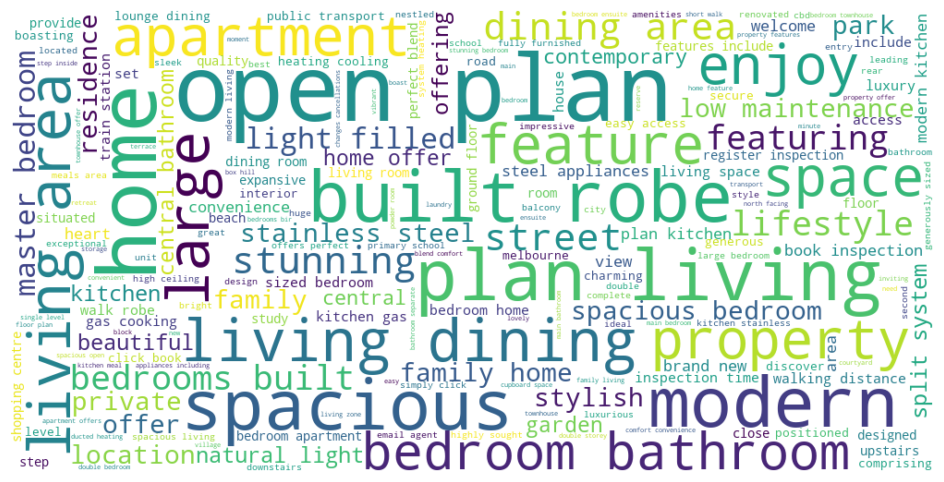

In [464]:
all_words = ' '.join([' '.join(tokens) for tokens in expensive['Cleaned_Tokens']])
wordcloud = WordCloud(
    width=1000, height=500, 
    background_color='white', 
    max_words=200, 
    max_font_size=100, 
).generate(all_words)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.show()

In [465]:
cheap = data_cleaned.loc[data_cleaned['Rent_Price'] <= Q3]
cheap.head(5)

URL  Rent_Price  \
0  https://www.domain.com.au/8-37-nepean-highway-...       415.0   
1  https://www.domain.com.au/2-8-beavis-street-el...       580.0   
2  https://www.domain.com.au/7-4-yorston-court-el...       515.0   
3  https://www.domain.com.au/3-360-glen-eira-road...       600.0   
4  https://www.domain.com.au/21-14-mcmillan-stree...       490.0   

                                       Address  Bedrooms  Bathrooms Parking  \
0    8/37 Nepean Highway, Elsternwick VIC 3185         1          1       1   
1      2-8 Beavis Street, Elsternwick VIC 3185         2          1       1   
2      7/4 Yorston Court, Elsternwick VIC 3185         2          1       1   
3   3/360 Glen Eira Road, Elsternwick VIC 3185         2          1       1   
4  21/14 McMillan Street, Elsternwick VIC 3185         2          1       1   

             Property_Type   Latitude   Longitude  \
0  Apartment / Unit / Flat -37.887226  145.000425   
1  Apartment / Unit / Flat -37.884698  145.007727   
2  Apartment / Unit / Flat -37.884660  145.008626   
3  Apartment / Unit / Flat -37.879255  145.015817   
4  Apartment / Unit / Flat -37.887122  145.001632   

                                   Property_Headline  ... SA2_CODE21  \
0  One Bedroom Apartment In Prime Location With A...  ...  208021179   
1                   We are now showing apartment 119  ...  208021179   
2  Stylish apartment with renovated bathroom and ...  ...  208021179   
3                          Delight in ideal location  ...  208021179   
4  PLEASE CLICK THE BELOW 'REQUEST AN INSPECTION'...  ...  208021179   

    SA2_NAME21 AREASQKM21                                         LOCI_URI21  \
0  Elsternwick     2.8616  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
1  Elsternwick     2.8616  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
2  Elsternwick     2.8616  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
3  Elsternwick     2.8616  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
4  Elsternwick     2.8616  http://linked.data.gov.au/dataset/asgsed3/SA2/...   

                                     suburb_geometry  Distance_Bin  \
0  POLYGON ((144.99708 -37.88178, 144.99715 -37.8...      10-15 km   
1  POLYGON ((144.99708 -37.88178, 144.99715 -37.8...      10-15 km   
2  POLYGON ((144.99708 -37.88178, 144.99715 -37.8...      10-15 km   
3  POLYGON ((144.99708 -37.88178, 144.99715 -37.8...      10-15 km   
4  POLYGON ((144.99708 -37.88178, 144.99715 -37.8...      10-15 km   

   Duration_Bin Distance_to_Nearest_Station_km StationDist_Bin  \
0     20-40 min                       0.352718   0.03-50.03 km   
1     20-40 min                       0.760244   0.03-50.03 km   
2     20-40 min                       0.860425   0.03-50.03 km   
3     20-40 min                       1.832867   0.03-50.03 km   
4     20-40 min                       0.343928   0.03-50.03 km   

                                      Cleaned_Tokens  
0  [click, register, receive, information, inspec...  
1  [opportunity, come, live, sought, buildings, e...  
2  [quiet, court, glen, huntly, road, level, apar...  
3  [tucked, away, private, leafy, courtyard, styl...  
4  [quiet, floor, apartment, positioned, rear, bl...  

[5 rows x 27 columns]

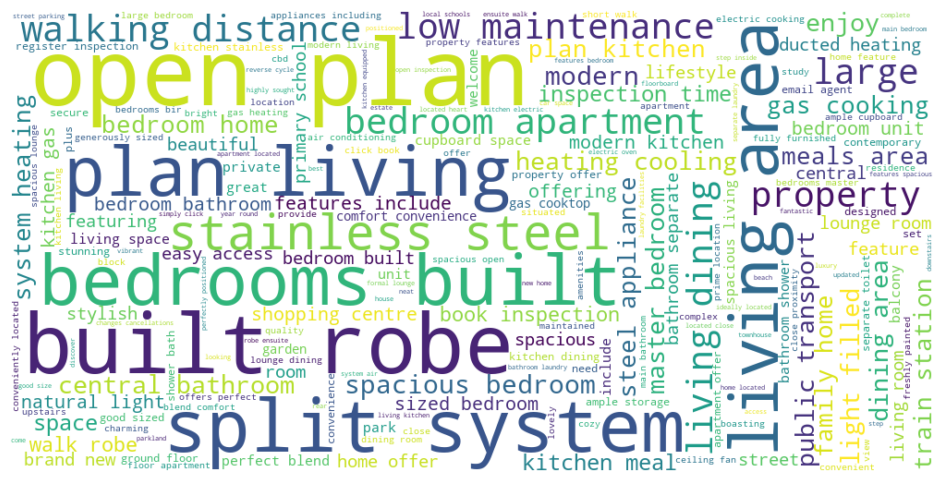

In [466]:
all_cheapwords = ' '.join([' '.join(tokens) for tokens in cheap['Cleaned_Tokens']])
wordcloud = WordCloud(
    width=1000, height=500, 
    background_color='white', 
    max_words=200, 
    max_font_size=100, 
).generate(all_cheapwords)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') 
plt.show()

In [467]:
from sklearn.feature_extraction.text import TfidfVectorizer
data_cleaned['Cleaned_Text'] = data_cleaned['Cleaned_Tokens'].apply(lambda x: ' '.join(x))
tfidf = TfidfVectorizer(max_features=500)

tfidf_matrix = tfidf.fit_transform(data_cleaned['Cleaned_Text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())
print(tfidf_df.head())

   abundance    access  accommodation  additional  adjoining  agent  air  \
0        0.0  0.000000            0.0         0.0        0.0    0.0  0.0   
1        0.0  0.157765            0.0         0.0        0.0    0.0  0.0   
2        0.0  0.000000            0.0         0.0        0.0    0.0  0.0   
3        0.0  0.000000            0.0         0.0        0.0    0.0  0.0   
4        0.0  0.000000            0.0         0.0        0.0    0.0  0.0   

   airy  alfresco  amenities  ...  welcome  welcoming  west  windows  wir  \
0   0.0       0.0        0.0  ...      0.0        0.0   0.0      0.0  0.0   
1   0.0       0.0        0.0  ...      0.0        0.0   0.0      0.0  0.0   
2   0.0       0.0        0.0  ...      0.0        0.0   0.0      0.0  0.0   
3   0.0       0.0        0.0  ...      0.0        0.0   0.0      0.0  0.0   
4   0.0       0.0        0.0  ...      0.0        0.0   0.0      0.0  0.0   

   wonderful  yard  yarra  year  zone  
0        0.0   0.0    0.0   0.0   0.0  


In [468]:
from textblob import TextBlob

def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity
data_cleaned['Sentiment'] = data_cleaned['Cleaned_Text'].apply(get_sentiment)

print(data_cleaned[['Property_Description', 'Sentiment']].head())

                                Property_Description  Sentiment
0  *** Please click "register now" to receive inf...   0.359524
1  An opportunity has come up to live in one of t...   0.134091
2  In a quiet court off Glen Huntly Road, this fi...   0.061111
3  Tucked away with its own private leafy courtya...   0.226190
4  QUIET TOP FLOOR APARTMENT POSITIONED AT THE RE...   0.095238


In [469]:
px.scatter(data_cleaned, x= 'Sentiment', y = "Rent_Price")

In [470]:
correlation_sent = data_cleaned['Sentiment'].corr(data_cleaned['Rent_Price'])
print(correlation_sent)

0.13439176528826116


### LDA for headline

In [471]:
data_cleaned['Property_Headline'] = data_cleaned['Property_Headline'].astype(str)
data_cleaned['Cleaned_HLTokens'] = data_cleaned['Property_Headline'].apply(clean_and_tokenize_spacy)

One Bedroom Apartment In Prime Location With A Study
We are now showing apartment 119
Stylish apartment with renovated bathroom and kitchen
Delight in ideal location
PLEASE CLICK THE BELOW 'REQUEST AN INSPECTION' BUTTON TO REGISTER FOR THE NEXT AVAILABLE INSPECTION
Headline Goes Here
Great two bedroom apartment
Brand New Large 2 Bedroom, 2 Bathroom apartment $725pw
Solid Comfort At Your Convenience
Secure Apartment in a great position with Solar Panels & 2 Storage Cages!
Two bedroom apartment with separate outdoor studio/home office
MODERN APARTMENT IN PLUMB ELSTERNWICK  LOCATION CLOSE TO SHOPS, TRAIN STATION AND TRAMS
Apartment for Lease in Elsternwick Prime Location, Modern Comfort
One bedroom apartment - whitegoods included
BRAND NEW APARTMENT WITH BALCONY & PARKING
Stunning renovated 2 bedroom apartment
EVERY ELSTERNWICK ADVANTAGE
RENOVATED APARTMENT IN GREAT LOCATION
Location Location Location!
Old World Charm
4- Bedroom-large - Fully Furnished unit in Elsternwick. Walkable to St 

In [474]:
from gensim import corpora
from gensim.models.ldamodel import LdaModel

dictionary = corpora.Dictionary(data_cleaned['Cleaned_HLTokens'])
corpus = [dictionary.doc2bow(text) for text in data_cleaned['Cleaned_HLTokens']]

lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10)

topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.149*"home" + 0.133*"location" + 0.087*"family" + 0.075*"bedroom" + 0.040*"prime"')
(1, '0.047*"home" + 0.042*"heart" + 0.033*"family" + 0.026*"beautiful" + 0.019*"convenient"')
(2, '0.101*"living" + 0.079*"modern" + 0.037*"apartment" + 0.025*"maintenance" + 0.023*"low"')
(3, '0.079*"bedroom" + 0.060*"apartment" + 0.037*"townhouse" + 0.035*"furnished" + 0.031*"stunning"')
(4, '0.085*"unit" + 0.068*"bedroom" + 0.034*"close" + 0.030*"central" + 0.028*"lease"')


In [491]:
data_cleaned

URL  Rent_Price  \
0     https://www.domain.com.au/8-37-nepean-highway-...       415.0   
1     https://www.domain.com.au/2-8-beavis-street-el...       580.0   
2     https://www.domain.com.au/7-4-yorston-court-el...       515.0   
3     https://www.domain.com.au/3-360-glen-eira-road...       600.0   
4     https://www.domain.com.au/21-14-mcmillan-stree...       490.0   
...                                                 ...         ...   
6102  https://www.domain.com.au/81-lake-mokoan-rd-go...       950.0   
6103  https://www.domain.com.au/1006-68-wests-road-m...       495.0   
6104  https://www.domain.com.au/605-68-wests-road-ma...       570.0   
6105  https://www.domain.com.au/506-8-horizon-drive-...       690.0   
6106  https://www.domain.com.au/3-runlet-drive-point...       600.0   

                                          Address  Bedrooms  Bathrooms  \
0       8/37 Nepean Highway, Elsternwick VIC 3185         1          1   
1         2-8 Beavis Street, Elsternwick VIC 3185         2          1   
2         7/4 Yorston Court, Elsternwick VIC 3185         2          1   
3      3/360 Glen Eira Road, Elsternwick VIC 3185         2          1   
4     21/14 McMillan Street, Elsternwick VIC 3185         2          1   
...                                           ...       ...        ...   
6102        81 Lake Mokoan Rd, Goorambat VIC 3725         4          2   
6103     1006/68 Wests Road, Maribyrnong VIC 3032         1          1   
6104      605/68 Wests Road, Maribyrnong VIC 3032         2          2   
6105    506/8 Horizon Drive, Maribyrnong VIC 3032         2          2   
6106          3 Runlet Drive, Point Cook VIC 3030         4          2   

     Parking            Property_Type   Latitude   Longitude  \
0          1  Apartment / Unit / Flat -37.887226  145.000425   
1          1  Apartment / Unit / Flat -37.884698  145.007727   
2          1  Apartment / Unit / Flat -37.884660  145.008626   
3          1  Apartment / Unit / Flat -37.879255  145.015817   
4          1  Apartment / Unit / Flat -37.887122  145.001632   
...      ...                      ...        ...         ...   
6102       8                    House -36.458867  146.012966   
6103       1  Apartment / Unit / Flat -37.769846  144.882360   
6104       1  Apartment / Unit / Flat -37.769846  144.882360   
6105       2  Apartment / Unit / Flat -37.775717  144.893061   
6106       2                    House -37.879970  144.725547   

                                      Property_Headline  ...  \
0     One Bedroom Apartment In Prime Location With A...  ...   
1                      We are now showing apartment 119  ...   
2     Stylish apartment with renovated bathroom and ...  ...   
3                             Delight in ideal location  ...   
4     PLEASE CLICK THE BELOW 'REQUEST AN INSPECTION'...  ...   
...                                                 ...  ...   
6102                    Stunning 360 Degree Rural Views  ...   
6103                              Upper-Level Apartment  ...   
6104  PLEASE CLICK THE BELOW 'REQUEST AN INSPECTION'...  ...   
6105                                Furnished Apartment  ...   
6106                     LARGE FOUR BEDROOM FAMILY HOME  ...   

                                             LOCI_URI21  \
0     http://linked.data.gov.au/dataset/asgsed3/SA2/...   
1     http://linked.data.gov.au/dataset/asgsed3/SA2/...   
2     http://linked.data.gov.au/dataset/asgsed3/SA2/...   
3     http://linked.data.gov.au/dataset/asgsed3/SA2/...   
4     http://linked.data.gov.au/dataset/asgsed3/SA2/...   
...                                                 ...   
6102  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
6103  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
6104  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
6105  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
6106  http://linked.data.gov.au/dataset/asgsed3/SA2/...   

                                        suburb_geometry Distanc

In [492]:
topic_labels = {
    0: "Family Homes in Prime Locations",
    1: "Beautiful, Convenient Family Homes",
    2: "Modern, Low-Maintenance Apartments",
    3: "Stunning Furnished Apartments/Townhouses",
    4: "Central Units for Lease"
}

data_cleaned['Dominant_Topic'] = [max(lda_model[corpus[i]], key=lambda x: x[1])[0] for i in range(len(corpus))]

data_cleaned['Dominant_Topic_Label'] = data_cleaned['Dominant_Topic'].map(topic_labels)

print(data_cleaned[['Property_Headline', 'Dominant_Topic_Label']].head())

                                   Property_Headline  \
0  One Bedroom Apartment In Prime Location With A...   
1                   We are now showing apartment 119   
2  Stylish apartment with renovated bathroom and ...   
3                          Delight in ideal location   
4  PLEASE CLICK THE BELOW 'REQUEST AN INSPECTION'...   

                       Dominant_Topic_Label  
0           Family Homes in Prime Locations  
1        Modern, Low-Maintenance Apartments  
2  Stunning Furnished Apartments/Townhouses  
3           Family Homes in Prime Locations  
4  Stunning Furnished Apartments/Townhouses  


In [494]:
data_cleaned

URL  Rent_Price  \
0     https://www.domain.com.au/8-37-nepean-highway-...       415.0   
1     https://www.domain.com.au/2-8-beavis-street-el...       580.0   
2     https://www.domain.com.au/7-4-yorston-court-el...       515.0   
3     https://www.domain.com.au/3-360-glen-eira-road...       600.0   
4     https://www.domain.com.au/21-14-mcmillan-stree...       490.0   
...                                                 ...         ...   
6102  https://www.domain.com.au/81-lake-mokoan-rd-go...       950.0   
6103  https://www.domain.com.au/1006-68-wests-road-m...       495.0   
6104  https://www.domain.com.au/605-68-wests-road-ma...       570.0   
6105  https://www.domain.com.au/506-8-horizon-drive-...       690.0   
6106  https://www.domain.com.au/3-runlet-drive-point...       600.0   

                                          Address  Bedrooms  Bathrooms  \
0       8/37 Nepean Highway, Elsternwick VIC 3185         1          1   
1         2-8 Beavis Street, Elsternwick VIC 3185         2          1   
2         7/4 Yorston Court, Elsternwick VIC 3185         2          1   
3      3/360 Glen Eira Road, Elsternwick VIC 3185         2          1   
4     21/14 McMillan Street, Elsternwick VIC 3185         2          1   
...                                           ...       ...        ...   
6102        81 Lake Mokoan Rd, Goorambat VIC 3725         4          2   
6103     1006/68 Wests Road, Maribyrnong VIC 3032         1          1   
6104      605/68 Wests Road, Maribyrnong VIC 3032         2          2   
6105    506/8 Horizon Drive, Maribyrnong VIC 3032         2          2   
6106          3 Runlet Drive, Point Cook VIC 3030         4          2   

     Parking            Property_Type   Latitude   Longitude  \
0          1  Apartment / Unit / Flat -37.887226  145.000425   
1          1  Apartment / Unit / Flat -37.884698  145.007727   
2          1  Apartment / Unit / Flat -37.884660  145.008626   
3          1  Apartment / Unit / Flat -37.879255  145.015817   
4          1  Apartment / Unit / Flat -37.887122  145.001632   
...      ...                      ...        ...         ...   
6102       8                    House -36.458867  146.012966   
6103       1  Apartment / Unit / Flat -37.769846  144.882360   
6104       1  Apartment / Unit / Flat -37.769846  144.882360   
6105       2  Apartment / Unit / Flat -37.775717  144.893061   
6106       2                    House -37.879970  144.725547   

                                      Property_Headline  ... Distance_Bin  \
0     One Bedroom Apartment In Prime Location With A...  ...     10-15 km   
1                      We are now showing apartment 119  ...     10-15 km   
2     Stylish apartment with renovated bathroom and ...  ...     10-15 km   
3                             Delight in ideal location  ...     10-15 km   
4     PLEASE CLICK THE BELOW 'REQUEST AN INSPECTION'...  ...     10-15 km   
...                                                 ...  ...          ...   
6102                    Stunning 360 Degree Rural Views  ...          NaN   
6103                              Upper-Level Apartment  ...      5-10 km   
6104  PLEASE CLICK THE BELOW 'REQUEST AN INSPECTION'...  ...      5-10 km   
6105                                Furnished Apartment  ...      5-10 km   
6106                     LARGE FOUR BEDROOM FAMILY HOME  ...     20-30 km   

     Duration_Bin Distance_to_Nearest_Station_km   StationDist_Bin  \
0       20-40 min                       0.352718     0.03-50.03 km   
1       20-40 min                       0.760244     0.03-50.03 km   
2       20-40 min                       0.860425     0.03-50.03 km   
3       20-40 min                       1.832867     0.03-50.03 km   
4       20-40 min                       0.343928     0.03-50.03 km   
...           ...                            ...               ...   
6102  140-160 min                     188.323594  150.03-200.03 km   
6103     0-20 min                       3.723252     0.0

In [495]:
topic_distribution = data_cleaned['Dominant_Topic_Label'].value_counts().reset_index()
topic_distribution.columns = ['Topic', 'Count']
fig = px.bar(topic_distribution, x='Topic', y='Count', title="Topic Distribution")
fig.show()


/Users/tinas/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/tinas/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [496]:
anova_result = stats.f_oneway(*[group['Rent_Price'].values for name, group in data_cleaned.groupby('Dominant_Topic_Label')])
print(f'ANOVA F-statistic: {anova_result.statistic}, p-value: {anova_result.pvalue}')

ANOVA F-statistic: 42.382931418680954, p-value: 4.583259552430176e-35


### BERT (desc)

In [484]:
BERT_categorised = pd.read_csv("../data/curated/categorised.csv").drop(["Unnamed: 0", "Unnamed: 0.1"], axis=1)

In [485]:
BERT_categorised

URL  Rent_Price  \
0     https://www.domain.com.au/8-37-nepean-highway-...       415.0   
1     https://www.domain.com.au/2-8-beavis-street-el...       580.0   
2     https://www.domain.com.au/7-4-yorston-court-el...       515.0   
3     https://www.domain.com.au/3-360-glen-eira-road...       600.0   
4     https://www.domain.com.au/21-14-mcmillan-stree...       490.0   
...                                                 ...         ...   
5518  https://www.domain.com.au/81-lake-mokoan-rd-go...       950.0   
5519  https://www.domain.com.au/1006-68-wests-road-m...       495.0   
5520  https://www.domain.com.au/605-68-wests-road-ma...       570.0   
5521  https://www.domain.com.au/506-8-horizon-drive-...       690.0   
5522  https://www.domain.com.au/3-runlet-drive-point...       600.0   

                                          Address  Bedrooms  Bathrooms  \
0       8/37 Nepean Highway, Elsternwick VIC 3185         1          1   
1         2-8 Beavis Street, Elsternwick VIC 3185         2          1   
2         7/4 Yorston Court, Elsternwick VIC 3185         2          1   
3      3/360 Glen Eira Road, Elsternwick VIC 3185         2          1   
4     21/14 McMillan Street, Elsternwick VIC 3185         2          1   
...                                           ...       ...        ...   
5518        81 Lake Mokoan Rd, Goorambat VIC 3725         4          2   
5519     1006/68 Wests Road, Maribyrnong VIC 3032         1          1   
5520      605/68 Wests Road, Maribyrnong VIC 3032         2          2   
5521    506/8 Horizon Drive, Maribyrnong VIC 3032         2          2   
5522          3 Runlet Drive, Point Cook VIC 3030         4          2   

     Parking            Property_Type   Latitude   Longitude  \
0          1  Apartment / Unit / Flat -37.887226  145.000425   
1          1  Apartment / Unit / Flat -37.884698  145.007727   
2          1  Apartment / Unit / Flat -37.884660  145.008626   
3          1  Apartment / Unit / Flat -37.879255  145.015817   
4          1  Apartment / Unit / Flat -37.887122  145.001632   
...      ...                      ...        ...         ...   
5518       8                    House -36.458867  146.012966   
5519       1  Apartment / Unit / Flat -37.769846  144.882360   
5520       1  Apartment / Unit / Flat -37.769846  144.882360   
5521       2  Apartment / Unit / Flat -37.775717  144.893061   
5522       2                    House -37.879970  144.725547   

                                      Property_Headline  ... AREASQKM21  \
0     One Bedroom Apartment In Prime Location With A...  ...     2.8616   
1                      We are now showing apartment 119  ...     2.8616   
2     Stylish apartment with renovated bathroom and ...  ...     2.8616   
3                             Delight in ideal location  ...     2.8616   
4     PLEASE CLICK THE BELOW 'REQUEST AN INSPECTION'...  ...     2.8616   
...                                                 ...  ...        ...   
5518                    Stunning 360 Degree Rural Views  ...  2105.3239   
5519                              Upper-Level Apartment  ...     5.4934   
5520  PLEASE CLICK THE BELOW 'REQUEST AN INSPECTION'...  ...     5.4934   
5521                                Furnished Apartment  ...     5.4934   
5522                     LARGE FOUR BEDROOM FAMILY HOME  ...     2.9380   

                                             LOCI_URI21  \
0     http://linked.data.gov.au/dataset/asgsed3/SA2/...   
1     http://linked.data.gov.au/dataset/asgsed3/SA2/...   
2     http://linked.data.gov.au/dataset/asgsed3/SA2/...   
3     http://linked.data.gov.au/dataset/asgsed3/SA2/...   
4     http://linked.data.gov.au/dataset/asgsed3/SA2/...   
...                                                 ...   
5518  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
5519  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
5520  http://linked.data.gov.au/dataset/asgsed3/SA2/...   
5521  http://linked.data.gov.au/dataset/asgsed3/SA

In [487]:
des_cat = BERT_categorised.groupby('Category')['Rent_Price'].mean().reset_index()
fig = px.bar(des_cat, x="Category", y="Rent_Price", 
             title="Average Rent Price by Distance to Descriptions Category",
             labels={'Rent_Price': 'Average Rent Price ($)', 'StationDist_Bin': 'Descriptions Category'})

fig.show()

/Users/tinas/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/tinas/anaconda3/lib/python3.11/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [489]:
anova_result = stats.f_oneway(*[group['Rent_Price'].values for name, group in BERT_categorised.groupby('Category')])
print(f'ANOVA F-statistic: {anova_result.statistic}, p-value: {anova_result.pvalue}')

ANOVA F-statistic: 80.61248809255324, p-value: 3.104335176889743e-35
